<a href="https://colab.research.google.com/github/ariel55/summerdata_visuchallenge/blob/main/001VisuChallenge_analisis_columnas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import librerias

In [3]:
# importando modulos necesarios
import numpy as np
import pandas as pd
#from pydataset import data
import re

# librerías de visualizaciones
import seaborn as sns
import matplotlib.pyplot as plt 
from bokeh.io import output_notebook, show
#from bokeh.charts import Histogram, Scatter
import folium

# graficos incrustados
%matplotlib inline
output_notebook()



# datos originales

In [4]:
data = pd.read_csv("/content/drive/My Drive/Datos/Entrenamieto_ECI_2020.csv")
data.head()

,ID,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Submitted_for_Approval,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,Opportunity_ID,Sales_Contract_No,Account_Owner,Opportunity_Owner,Account_Type,Opportunity_Type,Quote_Type,Delivery_Terms,Opportunity_Created_Date,Brand,Product_Type,Size,Product_Category_B,Price,Currency,Last_Activity,Quote_Expiry_Date,Last_Modified_Date,Last_Modified_By,Product_Family,Product_Name,ASP_Currency,ASP,ASP_(converted)_Currency,ASP_(converted),Planned_Delivery_Start_Date,Planned_Delivery_End_Date,Month,Delivery_Quarter,Delivery_Year,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A
0,27761,EMEA,None,1,1,1,1,0,Bureaucratic_Code_4,6/16/2015,None,Netherlands,Account_Name_619,Opportunity_Name_12598,0,None,Person_Name_51,Person_Name_18,Account_Type_2,Opportunity_Type_1,Non Binding,Delivery_Terms_2,12/7/2015,None,None,None,None,None,None,NaT,1/30/2016,6/13/2016,Person_Name_18,Product_Family_77,Product_Name_99,EUR,0.52,USD,0.58817,5/1/2016,6/30/2016,2016 - 5,Q2,2016,NaT,10,EUR,5272800.0,EUR,5272800.0,Closed Lost,Prod_Category_A_None
1,27760,EMEA,None,0,0,0,0,0,Bureaucratic_Code_4,6/16/2015,None,Netherlands,Account_Name_619,Opportunity_Name_12600,1,39,Person_Name_51,Person_Name_20,Account_Type_2,Opportunity_Type_1,Non Binding,Delivery_Terms_2,12/7/2015,None,None,None,None,None,None,NaT,1/20/2016,1/15/2016,Person_Name_20,Product_Family_77,Product_Name_100,EUR,0.53,USD,0.59948,1/18/2016,1/20/2016,2016 - 1,Q1,2016,NaT,0,EUR,48230.0,EUR,48230.0,Closed Won,Prod_Category_A_None
2,27446,Americas,NW America,0,0,0,0,0,Bureaucratic_Code_4,4/21/2015,Source_7,United States,Account_Name_1794,Opportunity_Name_469,2,760,Person_Name_64,Person_Name_8,Account_Type_5,Opportunity_Type_1,Non Binding,Delivery_Terms_4,12/8/2015,None,None,None,None,None,None,NaT,9/30/2016,9/29/2016,Person_Name_8,Product_Family_81,Product_Name_91,USD,0.48,USD,0.48000,1/25/2016,1/25/2016,2016 - 1,Q1,2016,NaT,0,USD,83865.6,USD,83865.6,Closed Won,Prod_Category_A_None
3,16808,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,7/27/2013,Source_11,United States,Account_Name_1201,Opportunity_Name_415,3,None,Person_Name_8,Person_Name_8,Account_Type_5,Opportunity_Type_19,Non Binding,Delivery_Terms_1,12/8/2015,Other,Product_Type_0,Size_4,Product_Category_B_16,0.42,USD,NaT,NaT,3/27/2018,Person_Name_8,Product_Family_209,Product_Name_432,USD,0.53,USD,0.53000,2/1/2018,3/31/2018,2018 - 2,Q1,2018,NaT,14,USD,7421881.5,USD,7421881.5,Closed Lost,Prod_Category_A_None
4,16805,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,7/27/2013,Source_11,United States,Account_Name_1201,Opportunity_Name_851,4,None,Person_Name_8,Person_Name_8,Account_Type_5,Opportunity_Type_19,Non Binding,Delivery_Terms_1,12/8/2015,Other,Product_Type_0,Size_4,Product_Category_B_16,0.42,USD,NaT,6/2/2017,3/27/2018,Person_Name_8,Product_Family_209,Product_Name_432,USD,0.53,USD,0.53000,2/1/2018,2/28/2018,2018 - 2,Q1,2018,NaT,25,USD,13357192.5,USD,13357192.5,Closed Lost,Prod_Category_A_None


# Limpieza y preprocesamiento de datos

In [5]:
# renombro columnas
data.rename(columns={'Source ':'Source', 'Pricing, Delivery_Terms_Quote_Appr':'Pricing, Delivery_Terms_Quote_Approval', 'ASP_(converted)':'ASP_(converted_to_usd)'}, inplace=True)

# 1 - Elimino la columna 'Submitted_for_Approval' porque todos sus valores son iguales a 0
# 2 - Elimino la columna 'Last_Activity' porque todos sus valores son iguales a NaT
# 3 - Elimino la columna 'ASP_(converted)_Currency' porque todos sus valores son iguales a USD
# 4 - Elimino la columna 'Actual_Delivery_Date' porque todos sus valores son iguales a NaT
# 5 - Elimino la columna 'Prod_Category_A' porque todos sus valores son iguales a Prod_Category_A_None
data.drop(['Submitted_for_Approval','Last_Activity', 'ASP_(converted)_Currency', 'Actual_Delivery_Date','Prod_Category_A'], axis=1, errors='ignore', inplace=True)

# convertir object a datetime
data['Account_Created_Date']        = pd.to_datetime(data['Account_Created_Date'], format='%m/%d/%Y', errors='coerce')
data['Opportunity_Created_Date']    = pd.to_datetime(data['Opportunity_Created_Date'], format='%m/%d/%Y', errors='coerce')
data['Quote_Expiry_Date']           = pd.to_datetime(data['Quote_Expiry_Date'], format='%m/%d/%Y', errors='coerce')
data['Last_Modified_Date']          = pd.to_datetime(data['Last_Modified_Date'], format='%m/%d/%Y', errors='coerce')
data['Planned_Delivery_Start_Date'] = pd.to_datetime(data['Planned_Delivery_Start_Date'], format='%m/%d/%Y', errors='coerce')
data['Planned_Delivery_End_Date']   = pd.to_datetime(data['Planned_Delivery_End_Date'], format='%m/%d/%Y', errors='coerce')

#se cambia el registro Planned_Delivery_End_Date=2208-12-31 por tener fecha invalida
data.loc[data['Planned_Delivery_End_Date']=='12/31/2208', ['Planned_Delivery_End_Date']] = '12/31/2018'
data.head()

,ID,Region,Territory,"Pricing, Delivery_Terms_Quote_Approval","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,Opportunity_ID,Sales_Contract_No,Account_Owner,Opportunity_Owner,Account_Type,Opportunity_Type,Quote_Type,Delivery_Terms,Opportunity_Created_Date,Brand,Product_Type,Size,Product_Category_B,Price,Currency,Quote_Expiry_Date,Last_Modified_Date,Last_Modified_By,Product_Family,Product_Name,ASP_Currency,ASP,ASP_(converted_to_usd),Planned_Delivery_Start_Date,Planned_Delivery_End_Date,Month,Delivery_Quarter,Delivery_Year,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage
0,27761,EMEA,None,1,1,1,1,Bureaucratic_Code_4,2015-06-16,None,Netherlands,Account_Name_619,Opportunity_Name_12598,0,None,Person_Name_51,Person_Name_18,Account_Type_2,Opportunity_Type_1,Non Binding,Delivery_Terms_2,2015-12-07,None,None,None,None,None,None,2016-01-30,2016-06-13,Person_Name_18,Product_Family_77,Product_Name_99,EUR,0.52,0.58817,2016-05-01,2016-06-30 00:00:00,2016 - 5,Q2,2016,10,EUR,5272800.0,EUR,5272800.0,Closed Lost
1,27760,EMEA,None,0,0,0,0,Bureaucratic_Code_4,2015-06-16,None,Netherlands,Account_Name_619,Opportunity_Name_12600,1,39,Person_Name_51,Person_Name_20,Account_Type_2,Opportunity_Type_1,Non Binding,Delivery_Terms_2,2015-12-07,None,None,None,None,None,None,2016-01-20,2016-01-15,Person_Name_20,Product_Family_77,Product_Name_100,EUR,0.53,0.59948,2016-01-18,2016-01-20 00:00:00,2016 - 1,Q1,2016,0,EUR,48230.0,EUR,48230.0,Closed Won
2,27446,Americas,NW America,0,0,0,0,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,2,760,Person_Name_64,Person_Name_8,Account_Type_5,Opportunity_Type_1,Non Binding,Delivery_Terms_4,2015-12-08,None,None,None,None,None,None,2016-09-30,2016-09-29,Person_Name_8,Product_Family_81,Product_Name_91,USD,0.48,0.48000,2016-01-25,2016-01-25 00:00:00,2016 - 1,Q1,2016,0,USD,83865.6,USD,83865.6,Closed Won
3,16808,Americas,NW America,1,0,1,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_415,3,None,Person_Name_8,Person_Name_8,Account_Type_5,Opportunity_Type_19,Non Binding,Delivery_Terms_1,2015-12-08,Other,Product_Type_0,Size_4,Product_Category_B_16,0.42,USD,NaT,2018-03-27,Person_Name_8,Product_Family_209,Product_Name_432,USD,0.53,0.53000,2018-02-01,2018-03-31 00:00:00,2018 - 2,Q1,2018,14,USD,7421881.5,USD,7421881.5,Closed Lost
4,16805,Americas,NW America,1,0,1,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_851,4,None,Person_Name_8,Person_Name_8,Account_Type_5,Opportunity_Type_19,Non Binding,Delivery_Terms_1,2015-12-08,Other,Product_Type_0,Size_4,Product_Category_B_16,0.42,USD,2017-06-02,2018-03-27,Person_Name_8,Product_Family_209,Product_Name_432,USD,0.53,0.53000,2018-02-01,2018-02-28 00:00:00,2018 - 2,Q1,2018,25,USD,13357192.5,USD,13357192.5,Closed Lost


In [6]:
ultimo_ID = data.nlargest(1,'ID').reset_index().loc[0,'ID']
primero_ID = data.nsmallest(1,'ID').reset_index().loc[0,'ID']
print (ultimo_ID, '-', primero_ID, ' = ', ultimo_ID - primero_ID, ', len=', len(data))

28773 - 4854  =  23919 , len= 16947


# Funciones

In [106]:
def count_none ( column ):
  count = 0
  for i in data.index:
    if data[column][i] == 'None':
      count += 1
      
  return count

def count_NaT ( column ):
  count = 0
  for i in data.index:
    if data[column][i] == 'NaT':
      count += 1
      
  return count

def convertMonth( month ):
  result = month
  if len(month) == 8:
    nro_month = str.split(month)[2]
    result = month[:7]+'0'+nro_month
  return result

# example
#convertMonth("2016 - 5")

#data['Month_sortable'] = data["Month"].apply(lambda x: convertMonth(x) )

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16947 entries, 0 to 16946
Data columns (total 47 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   ID                                      16947 non-null  int64         
 1   Region                                  16947 non-null  object        
 2   Territory                               16947 non-null  object        
 3   Pricing, Delivery_Terms_Quote_Approval  16947 non-null  int64         
 4   Pricing, Delivery_Terms_Approved        16947 non-null  int64         
 5   Bureaucratic_Code_0_Approval            16947 non-null  int64         
 6   Bureaucratic_Code_0_Approved            16947 non-null  int64         
 7   Bureaucratic_Code                       16947 non-null  object        
 8   Account_Created_Date                    16947 non-null  datetime64[ns]
 9   Source                                  16947 non-

In [9]:
data['Region'].value_counts(normalize=True)

Japan          0.288665
EMEA           0.275211
Americas       0.232785
APAC           0.192482
Middle East    0.010857
Name: Region, dtype: float64

In [10]:
data['Territory_none'] =  data['Territory'] == 'None'
data['Territory_none'].value_counts(normalize=True)

False    0.705022
True     0.294978
Name: Territory_none, dtype: float64

In [11]:
data['Pricing, Delivery_Terms_Quote_Approval'].value_counts(normalize=True)

1    0.80799
0    0.19201
Name: Pricing, Delivery_Terms_Quote_Approval, dtype: float64

In [12]:
data['Pricing, Delivery_Terms_Approved'].value_counts(normalize=True)

1    0.583584
0    0.416416
Name: Pricing, Delivery_Terms_Approved, dtype: float64

In [13]:
data['Bureaucratic_Code_0_Approval'].value_counts(normalize=True)

0    0.524518
1    0.475482
Name: Bureaucratic_Code_0_Approval, dtype: float64

In [14]:
data['Bureaucratic_Code_0_Approved'].value_counts(normalize=True)

0    0.681124
1    0.318876
Name: Bureaucratic_Code_0_Approved, dtype: float64

In [15]:
data['Bureaucratic_Code'].value_counts(normalize=True)

Bureaucratic_Code_4    0.742727
Bureaucratic_Code_5    0.224405
Bureaucratic_Code_1    0.015401
Bureaucratic_Code_2    0.014280
Bureaucratic_Code_0    0.003009
Bureaucratic_Code_3    0.000118
Bureaucratic_Code_6    0.000059
Name: Bureaucratic_Code, dtype: float64

In [16]:
data['Account_Created_Date_year'] = pd.DatetimeIndex(data['Account_Created_Date']).year
data['Account_Created_Date_year'].value_counts(normalize=False)

2015    4927
2013    4550
2016    3115
2017    2210
2014    1381
2018     764
Name: Account_Created_Date_year, dtype: int64

In [17]:
data['Source_none'] =  data['Source'] == 'None'
data['Source_none'].value_counts(normalize=True)

True     0.560394
False    0.439606
Name: Source_none, dtype: float64

In [18]:
data['Source'].value_counts(normalize=True) #Nota: No aparece el Source_8

None         0.560394
Source_7     0.174957
Source_9     0.086092
Source_11    0.083850
Source_13    0.046380
Source_3     0.024665
Source_1     0.008084
Source_10    0.006255
Source_2     0.005075
Source_4     0.002537
Source_6     0.001121
Source_0     0.000413
Source_12    0.000118
Source_5     0.000059
Name: Source, dtype: float64

In [19]:
data['Billing_Country_none'] =  data['Billing_Country'] == 'None'
data['Billing_Country_none'].value_counts(normalize=True)

False    0.998407
True     0.001593
Name: Billing_Country_none, dtype: float64

In [20]:
data['Billing_Country'].value_counts(normalize=True)

Japan                     0.287898
United States             0.224346
Germany                   0.116776
Australia                 0.068980
India                     0.039653
                            ...   
Oman                      0.000059
Bosnia and Herzegovina    0.000059
Bangladesh                0.000059
Kenya                     0.000059
Liechtenstein             0.000059
Name: Billing_Country, Length: 80, dtype: float64

In [21]:
data['Account_Name'].value_counts(normalize=True)

Account_Name_1888    0.125332
Account_Name_1836    0.052281
Account_Name_25      0.044374
Account_Name_1991    0.034578
Account_Name_1642    0.023426
                       ...   
Account_Name_1456    0.000059
Account_Name_405     0.000059
Account_Name_429     0.000059
Account_Name_759     0.000059
Account_Name_1825    0.000059
Name: Account_Name, Length: 1635, dtype: float64

In [22]:
data['Opportunity_Name'].value_counts(normalize=False)

Opportunity_Name_5036     36
Opportunity_Name_9795     36
Opportunity_Name_12179    26
Opportunity_Name_11461    26
Opportunity_Name_6835     24
                          ..
Opportunity_Name_3215      1
Opportunity_Name_10918     1
Opportunity_Name_10900     1
Opportunity_Name_3883      1
Opportunity_Name_4913      1
Name: Opportunity_Name, Length: 9841, dtype: int64

In [23]:
data['Opportunity_ID'].value_counts(normalize=True)

12460    0.002124
2008     0.002124
5123     0.001534
6606     0.001534
2911     0.001416
           ...   
7482     0.000059
5435     0.000059
3400     0.000059
7498     0.000059
0        0.000059
Name: Opportunity_ID, Length: 9841, dtype: float64

In [24]:
data['Sales_Contract_No'].value_counts(normalize=True)

None    0.411459
108     0.002124
479     0.002124
2575    0.001062
5583    0.000944
          ...   
794     0.000059
1138    0.000059
366     0.000059
1185    0.000059
5014    0.000059
Name: Sales_Contract_No, Length: 5267, dtype: float64

In [25]:
data['Account_Owner'].value_counts(normalize=False).head(10)

Person_Name_50    3730
Person_Name_13    1328
Person_Name_8     1286
Person_Name_43    1241
Person_Name_18    1093
Person_Name_3      875
Person_Name_32     682
Person_Name_4      664
Person_Name_65     631
Person_Name_64     577
Name: Account_Owner, dtype: int64

In [26]:
data['Opportunity_Owner'].value_counts(normalize=False).head(10)

Person_Name_50    3781
Person_Name_8     1422
Person_Name_13    1254
Person_Name_18     982
Person_Name_43     838
Person_Name_3      832
Person_Name_4      687
Person_Name_32     686
Person_Name_19     615
Person_Name_64     516
Name: Opportunity_Owner, dtype: int64

In [27]:
data['Account_Type'].value_counts(normalize=False).head(10)

Account_Type_2    8832
Account_Type_0    5868
Account_Type_5    1943
Account_Type_1     165
None               112
Account_Type_6      17
Account_Type_4      10
Name: Account_Type, dtype: int64

In [28]:
data['Opportunity_Type'].value_counts(normalize=False).head(10)

Opportunity_Type_1     6819
Opportunity_Type_7     5763
Opportunity_Type_19    1900
Opportunity_Type_8     1458
Opportunity_Type_12     279
Opportunity_Type_3      275
Opportunity_Type_20     175
Opportunity_Type_2       70
Opportunity_Type_4       51
Opportunity_Type_10      34
Name: Opportunity_Type, dtype: int64

In [29]:
data['Quote_Type'].value_counts(normalize=False).head(10)

Non Binding    16777
Binding          170
Name: Quote_Type, dtype: int64

In [30]:
data['Delivery_Terms'].value_counts(normalize=False).head(10)

Delivery_Terms_4    7712
Delivery_Terms_2    4633
Delivery_Terms_1    2936
Delivery_Terms_6     781
Delivery_Terms_5     636
Delivery_Terms_8     164
Delivery_Terms_3      41
Delivery_Terms_7      38
Delivery_Terms_0       6
Name: Delivery_Terms, dtype: int64

In [31]:
data['Opportunity_Created_Date_year'] = pd.DatetimeIndex(data['Opportunity_Created_Date']).year
data['Opportunity_Created_Date_year'].value_counts(normalize=False)

2017    6921
2018    4618
2016    4355
2015    1012
2014      40
2013       1
Name: Opportunity_Created_Date_year, dtype: int64

In [32]:
data['Brand'].value_counts(normalize=False).head(10)

None        15911
Other         607
Brand_9       140
Brand_5        48
Brand_24       38
Brand_11       34
Brand_25       24
Brand_10       22
Brand_22       20
Brand_21       17
Name: Brand, dtype: int64

In [33]:
data['Product_Type'].value_counts(normalize=False).head(10)

None              15935
Other               515
Product_Type_3      179
Product_Type_1      142
Product_Type_0       94
Product_Type_4       73
Product_Type_2        9
Name: Product_Type, dtype: int64

In [34]:
data['Size'].value_counts(normalize=False).head(10)

None      15967
Other       394
Size_3      356
Size_4      196
Size_1       25
Size_0        7
Size_2        2
Name: Size, dtype: int64

In [35]:
data['Product_Category_B'].value_counts(normalize=False).head(10)

None                     15928
Other                      523
Product_Category_B_2        59
Product_Category_B_12       51
Product_Category_B_7        47
Product_Category_B_4        37
Product_Category_B_5        36
Product_Category_B_17       27
Product_Category_B_1        24
Product_Category_B_3        23
Name: Product_Category_B, dtype: int64

In [36]:
data['Price_none'] =  data['Price'] == 'None'
data['Price_none'].value_counts(normalize=True)

True     0.943058
False    0.056942
Name: Price_none, dtype: float64

In [37]:
data['Currency'].value_counts(normalize=False).head(10)

None    16052
EUR       475
USD       420
Name: Currency, dtype: int64

In [38]:
count_NaT('Quote_Expiry_Date')

0

In [39]:
data['Quote_Expiry_Date_year'] = pd.DatetimeIndex(data['Quote_Expiry_Date']).year
data['Quote_Expiry_Date_year'].value_counts(normalize=False)

2017.0    5681
2018.0    3333
2016.0    2936
2015.0     291
2019.0      79
2014.0       2
Name: Quote_Expiry_Date_year, dtype: int64

In [40]:
data['Last_Modified_Date_year'] = pd.DatetimeIndex(data['Last_Modified_Date']).year
data['Last_Modified_Date_year'].value_counts(normalize=False)

2018    11737
2016     3817
2017     1219
2015      174
Name: Last_Modified_Date_year, dtype: int64

In [41]:
data['Last_Modified_By'].value_counts(normalize=False).head(10)

Person_Name_47    8515
Person_Name_50    1210
Person_Name_43     587
Person_Name_13     578
Person_Name_8      511
Person_Name_18     438
Person_Name_33     429
Person_Name_3      395
Person_Name_19     395
Person_Name_4      315
Name: Last_Modified_By, dtype: int64

In [42]:
data['Product_Family'].value_counts(normalize=False).head(10)

Product_Family_77     1345
Product_Family_133    1249
Product_Family_132     763
Product_Family_212     636
Product_Family_100     619
Product_Family_85      596
Product_Family_115     540
Product_Family_226     524
Product_Family_109     499
Product_Family_208     478
Name: Product_Family, dtype: int64

In [43]:
data['Product_Name'].value_counts(normalize=True).head(10) # distribucion uniforme

Product_Name_100    0.057591
Product_Name_226    0.049330
Product_Name_231    0.034165
Product_Name_491    0.030920
Product_Name_4      0.027970
Product_Name_192    0.026081
Product_Name_111    0.022895
Product_Name_132    0.022600
Product_Name_495    0.020653
Product_Name_29     0.020358
Name: Product_Name, dtype: float64

In [44]:
data['ASP_Currency'].value_counts(normalize=False).head(10)

USD    7361
JPY    4522
EUR    4503
AUD     556
GBP       5
Name: ASP_Currency, dtype: int64

In [45]:
data['ASP'].value_counts(normalize=True).head(10)*100 # distribucion uniforme

0.380    5.830543
0.400    5.182705
0.360    4.105401
0.420    3.712331
0.390    3.384772
0.370    2.656864
0.000    2.191003
0.350    2.147329
0.340    1.965352
0.365    1.958072
Name: ASP, dtype: float64

In [46]:
data['ASP_(converted_to_usd)'].value_counts(normalize=False).head(10)

0.38000    570
0.40000    497
0.36000    326
0.39000    325
0.00000    300
0.42000    294
0.40719    234
0.42982    230
0.47506    216
0.45244    214
Name: ASP_(converted_to_usd), dtype: int64

In [47]:
data['Planned_Delivery_Start_Date_year'] = pd.DatetimeIndex(data['Planned_Delivery_Start_Date']).year
data['Planned_Delivery_Start_Date_year'].value_counts(normalize=False)

2017    6318
2018    5830
2016    4371
2019     414
2020      14
Name: Planned_Delivery_Start_Date_year, dtype: int64

In [48]:
data['Planned_Delivery_End_Date_year'] = pd.DatetimeIndex(data['Planned_Delivery_End_Date']).year
data['Planned_Delivery_End_Date_year'].value_counts(normalize=False)

2017.0    6284
2018.0    5829
2016.0    4301
2019.0     440
2020.0      17
2021.0       1
Name: Planned_Delivery_End_Date_year, dtype: int64

In [49]:
data['Month'].value_counts(normalize=False).head(10)

2018 - 10    666
2017 - 6     643
2017 - 10    638
2016 - 3     628
2017 - 7     625
2017 - 5     586
2018 - 4     579
2017 - 12    574
2018 - 6     542
2018 - 7     536
Name: Month, dtype: int64

In [50]:
data['Delivery_Quarter'].value_counts(normalize=False).head(10)

Q2    4443
Q1    4317
Q4    4144
Q3    4043
Name: Delivery_Quarter, dtype: int64

In [51]:
data['Delivery_Year'].value_counts(normalize=False).head(10)

2017    6318
2018    5830
2016    4371
2019     414
2020      14
Name: Delivery_Year, dtype: int64

In [52]:
data['TRF'].value_counts(normalize=False).head(10)

0     11971
1      2192
2       627
3       354
5       297
4       208
10      190
6       131
7       111
20       83
Name: TRF, dtype: int64

In [53]:
data['Total_Amount_Currency'].value_counts(normalize=False).head(10)

USD    7361
JPY    4522
EUR    4503
AUD     556
GBP       5
Name: Total_Amount_Currency, dtype: int64

In [54]:
data['Total_Taxable_Amount_Currency'].value_counts(normalize=False).head(10)

USD    7347
JPY    4525
EUR    4518
AUD     553
GBP       4
Name: Total_Taxable_Amount_Currency, dtype: int64

In [55]:
data['Total_Taxable_Amount'].value_counts(normalize=False).head(10)

0.0           997
588325.0       72
109620.0       68
488700.0       66
413700.0       60
552400.0       60
1767640.0      48
523100.0       40
105840.0       37
31053609.6     36
Name: Total_Taxable_Amount, dtype: int64

In [56]:
data['Stage'].value_counts(normalize=False).head(10)

Closed Won       9533
Closed Lost      7350
Proposal           35
Negotiation        18
Qualification      11
Name: Stage, dtype: int64

In [57]:
data.columns

Index(['ID', 'Region', 'Territory', 'Pricing, Delivery_Terms_Quote_Approval',
       'Pricing, Delivery_Terms_Approved', 'Bureaucratic_Code_0_Approval',
       'Bureaucratic_Code_0_Approved', 'Bureaucratic_Code',
       'Account_Created_Date', 'Source', 'Billing_Country', 'Account_Name',
       'Opportunity_Name', 'Opportunity_ID', 'Sales_Contract_No',
       'Account_Owner', 'Opportunity_Owner', 'Account_Type',
       'Opportunity_Type', 'Quote_Type', 'Delivery_Terms',
       'Opportunity_Created_Date', 'Brand', 'Product_Type', 'Size',
       'Product_Category_B', 'Price', 'Currency', 'Quote_Expiry_Date',
       'Last_Modified_Date', 'Last_Modified_By', 'Product_Family',
       'Product_Name', 'ASP_Currency', 'ASP', 'ASP_(converted_to_usd)',
       'Planned_Delivery_Start_Date', 'Planned_Delivery_End_Date', 'Month',
       'Delivery_Quarter', 'Delivery_Year', 'TRF', 'Total_Amount_Currency',
       'Total_Amount', 'Total_Taxable_Amount_Currency', 'Total_Taxable_Amount',
       'Stage',

In [58]:
len(data.columns)

57

# Visualizaciones

In [59]:
country = data["Billing_Country"].value_counts().to_frame().reset_index()
country_20 = country.nlargest(20, "Billing_Country")

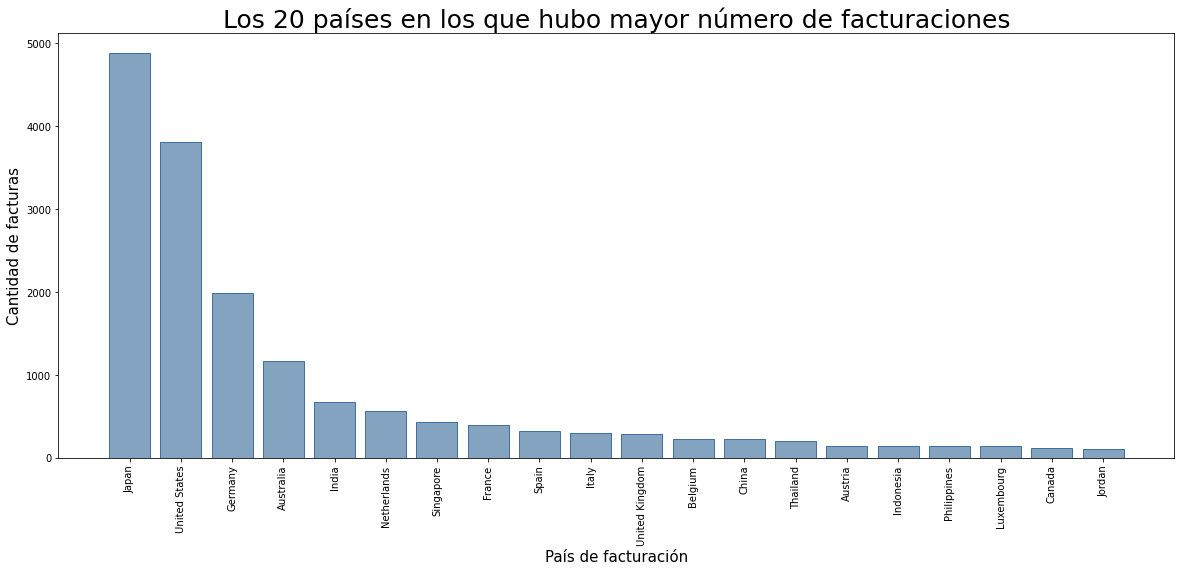

In [60]:
plt.figure(figsize=(20,10))
 
# Choose the height of the bars
height = list(country_20["Billing_Country"])
 
# Choose the names of the bars
bars = list(country_20["index"])
y_pos = np.arange(len(bars))
 
# Create bars
plt.bar(y_pos, height, color=(0.2, 0.4, 0.6, 0.6), edgecolor=(0.2, 0.4, 0.6, 0.9))
 
# Rotation of the bars names
plt.xticks(y_pos, bars, rotation=90)
 
# Custom the subplot layout
plt.subplots_adjust(bottom=0.4, top=0.99)
plt.xlabel('País de facturación',fontsize=15)
plt.ylabel('Cantidad de facturas',fontsize=15)
plt.title("Los 20 países en los que hubo mayor número de facturaciones",fontsize=25)
 
# Show graphic
plt.show()

In [61]:
data['Opportunity_Name'].value_counts()

Opportunity_Name_5036     36
Opportunity_Name_9795     36
Opportunity_Name_12179    26
Opportunity_Name_11461    26
Opportunity_Name_6835     24
                          ..
Opportunity_Name_3215      1
Opportunity_Name_10918     1
Opportunity_Name_10900     1
Opportunity_Name_3883      1
Opportunity_Name_4913      1
Name: Opportunity_Name, Length: 9841, dtype: int64

In [111]:
filtro = (data['Source_none']==True) & (data['Delivery_Year'] != 2020) & (data['Stage'] == 'Closed Won') & (data['Total_Amount_Currency'] == 'USD')
data.rename(columns={'Total_Amount':'Total_Amount_USD'}, inplace=True)

data.groupby(['Opportunity_Name','Stage'])['Opportunity_Name'].count()
data.loc[ filtro, 'Opportunity_Name'].value_counts()
mejores_vendedores_usd = data.loc[filtro].groupby('Opportunity_Owner').agg({'Total_Amount_USD':'sum'}).nlargest(10, 'Total_Amount_USD').reset_index()
mejores_vendedores_usd.head(50)

,Opportunity_Owner,Total_Amount_USD
0,Person_Name_8,2.644783e+08
1,Person_Name_46,3.689580e+07
2,Person_Name_49,3.646339e+07
3,Person_Name_13,3.160210e+07
4,Person_Name_3,3.038965e+07
5,Person_Name_54,1.346285e+07
6,Person_Name_64,1.218923e+07
7,Person_Name_60,1.201328e+07
8,Person_Name_19,8.812718e+06
9,Person_Name_43,7.405165e+06


In [113]:
variaciones_ventas = data[ (data['Opportunity_Owner'].isin(list(mejores_vendedores_usd['Opportunity_Owner'])) ) & filtro]
variaciones_ventas[['Opportunity_Owner', 'Delivery_Year', 'Total_Amount_USD']]

,Opportunity_Owner,Delivery_Year,Total_Amount_USD
23,Person_Name_49,2016,1621851.0
64,Person_Name_8,2016,3184974.0
77,Person_Name_60,2016,3920.0
435,Person_Name_49,2016,46020.0
572,Person_Name_19,2016,22950.0
...,...,...,...
16502,Person_Name_3,2016,101500.0
16667,Person_Name_8,2016,15080039.0
16759,Person_Name_8,2016,14430065.0
16827,Person_Name_13,2016,305235.0


In [116]:
variaciones_ventas = variaciones_ventas.groupby(['Opportunity_Owner','Delivery_Year']).agg({'Total_Amount_USD':'sum'})
variaciones_ventas.fillna(0)
mejores_ventas = variaciones_ventas.sort_values(by=['Opportunity_Owner','Delivery_Year']).reset_index()
mejores_ventas.head(12)

,Opportunity_Owner,Delivery_Year,Total_Amount_USD
0,Person_Name_13,2016,878535.00
1,Person_Name_13,2017,27066420.00
2,Person_Name_13,2018,3657150.00
3,Person_Name_19,2016,2532410.96
4,Person_Name_19,2017,5725662.65
5,Person_Name_19,2018,449329.78
6,Person_Name_19,2019,105315.00
7,Person_Name_3,2016,3677364.15
8,Person_Name_3,2017,16696604.38
9,Person_Name_3,2018,9991089.91


In [117]:
table = pd.pivot_table(mejores_ventas, values='Total_Amount_USD', index=['Delivery_Year'], columns=['Opportunity_Owner'], aggfunc='sum').reset_index().fillna(0)
table = table.set_index('Delivery_Year')
table


Opportunity_Owner,Person_Name_13,Person_Name_19,Person_Name_3,Person_Name_43,Person_Name_46,Person_Name_49,Person_Name_54,Person_Name_60,Person_Name_64,Person_Name_8
Delivery_Year,,,,,,,,,,
2016,878535.0,2532410.96,3677364.15,0.00,0.00,16549152.90,1919938.90,1718389.40,0.00,2.302404e+08
2017,27066420.0,5725662.65,16696604.38,615466.00,4200574.88,18325772.56,9004594.90,9902698.76,3878287.13,2.205413e+06
2018,3657150.0,449329.78,9991089.91,6789699.15,32695225.55,1588464.00,2538315.79,392188.95,8158289.03,7.487613e+06
2019,0.0,105315.00,24591.60,0.00,0.00,0.00,0.00,0.00,152655.00,2.454489e+07


Text(0.5, 1.0, 'Los mejores 10 vendedores sin fuente de creación de oportunidad en los últimos 4 años.')

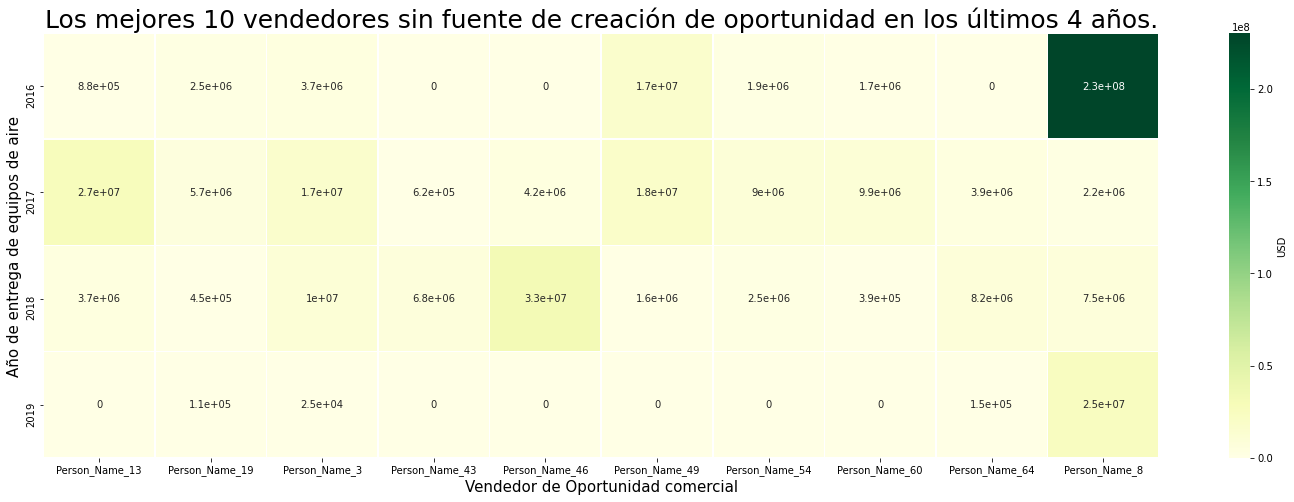

In [121]:
plt.figure(figsize=(25,10))
sns.heatmap(table, cmap ='YlGn', linewidths = 0.60, annot = True, cbar_kws={'label': 'USD'}) 

# Custom the subplot layout
plt.subplots_adjust(bottom=0.4, top=0.99)
plt.xlabel('Vendedor de Oportunidad comercial',fontsize=15)
plt.ylabel('Año de entrega de equipos de aire',fontsize=15)
plt.title("Los mejores 10 vendedores sin fuente de creación de oportunidad en los últimos 4 años.",fontsize=25)